In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import transpile
from qiskit.transpiler.passes import Depth
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator
from qiskit.circuit import Delay

import matplotlib.pyplot as plt
import math
import numpy as np

import sys
import os

sys.path.append(os.path.abspath("..\\..\\.."))
from objects.steane_code_circuit import SteaneCodeCircuit
from functions import *


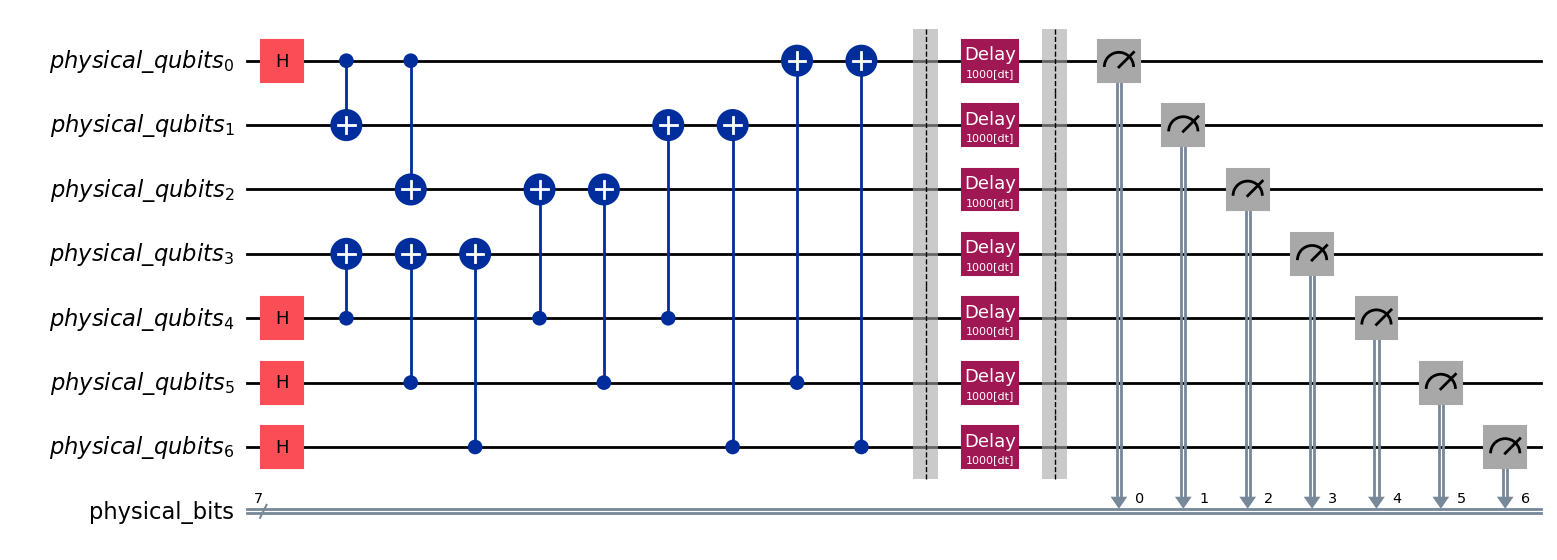

In [2]:
def load_circuit(delay):
    qc = SteaneCodeCircuit(1)

    qc.physical_quantum_circuit.h(0)
    qc.encode(append=True)

    qc.barrier()
    qc.delay(delay)
    qc.barrier()
    
    qc.measure_all(basis='all')

    return qc

qc = load_circuit(1000)
qc.draw_physical_circuit('mpl')

In [11]:
ibm_token = ""
service = QiskitRuntimeService(channel="ibm_quantum", token=ibm_token)
backend = service.backend("ibm_kyiv")

In [12]:
phy_qc = qc.physical_quantum_circuit
isa_circuit = transpile(phy_qc, backend, scheduling_method="asap", optimization_level=3)
print(f"Circuit Depth: {qc.physical_quantum_circuit.depth()}")
print(f"Transpiled Circuit Depth: {isa_circuit.depth()}")


Circuit Depth: 9
Transpiled Circuit Depth: 61


In [13]:
dt = backend.configuration().dt * 10**9
print(f'dt = {round(dt, 3)} ns')

dt = 0.222 ns


In [15]:
t_array = [t*180_000 for t in range(0, 3)]
print([round(t*dt * 10**(-3), 3) for t in t_array])

[0.0, 40.0, 80.0]


In [ ]:
circuits = []

for t in t_array:

    qc = load_circuit(t)

    isa_circuit = get_transpile(qc.physical_quantum_circuit, backend, iterations=50,
                                # initial_layout=[60, 53, 61, 59, 41, 42, 43]
                                )
    
    circuits.append(isa_circuit)

    print(f"Circuit Depth: {circuits[-1].depth()}")
    print(f"Delay Duration: {round(t*dt * 10**(-3), 3)} us")
    print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} us")
    print(get_layout(circuits[-1], qb_len=7))
    print('\n')

Circuit Depth: 54
Delay Duration: 0.0 us
Total Duration: 10.574 us
[60, 53, 61, 59, 41, 42, 43]




C:\Users\marzu\AppData\Local\Temp\ipykernel_16808\963337880.py:15: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} us")


Circuit Depth: 55
Delay Duration: 40.0 us
Total Duration: 50.574 us
[60, 53, 61, 59, 41, 42, 43]




C:\Users\marzu\AppData\Local\Temp\ipykernel_16808\963337880.py:15: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} us")


Circuit Depth: 55
Delay Duration: 80.0 us
Total Duration: 90.574 us
[60, 53, 61, 59, 41, 42, 43]




C:\Users\marzu\AppData\Local\Temp\ipykernel_16808\963337880.py:15: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} us")


In [17]:
simulation_result = {
    key[::-1]: value for key, value in
    sampler_simulation(qc.physical_quantum_circuit, 12800).data[qc.physical_bit_register.name].get_counts().items()
}

print([s for s in simulation_result])


['1110000', '0010110', '1100110', '0000000', '0111100', '1111111', '0101010', '0110011', '1011010', '1101001', '0001111', '1001100', '0100101', '1010101', '1000011', '0011001']


In [24]:
sampler = SamplerV2(backend=backend)
shots = 12800
# job = sampler.run(circuits, shots=shots)
job = service.job('cz19n1410wx0008aynr0') # sherbrooke, shots = 12800, t_array = [0]
# job = service.job('cz1r96cp6030008c046g') # t_array = [t*90_000 for t in range(0, 3)] -> descartar
# job = service.job('cz2k995p6030008c49xg') # kyiv, t_array = [t*180_000 for t in range(0, 3)]

pub_result = job.result()

In [25]:
states = [bin(i)[2:].zfill(7) for i in range(2**7)]
valid_states = ['0110011', '0001111', '0100101', '0101010', '1110000', '0111100', '1011010', '1111111', '1010101', '1000011', '1100110', '0010110', '0000000', '1101001', '0011001', '1001100']

results = extract_results_IBM(pub_result, type='percentage')[qc.physical_bit_register.name]


TVD

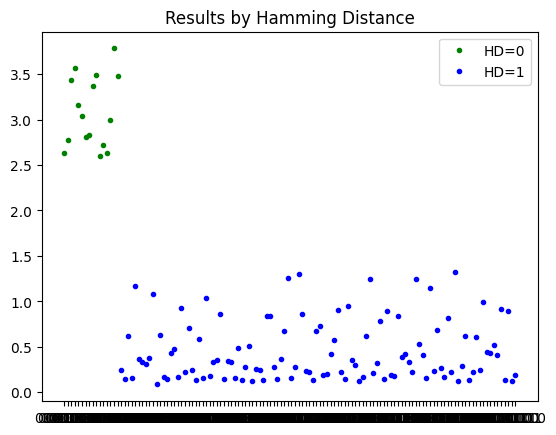

In [26]:
for r in results:
    plot_results_hamming_distance(r, 7, valid_states)

In [27]:
tvd = [calculate_tvd(r, generate_uniform_distribution(7, valid_states), percentage=True) for r in results]
for i in range(len(tvd)):
    print(f"TVD step{i}: {round(tvd[i]*100,2)}%")

TVD step0: 50.69%
